In [1]:
import pandas as pd
import os
import re
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
os.getcwd()

'/mnt/c/Users/seanp/git_repos/tbng_veg/prep/veg_prep'

# Create initial datasets

### Setup input/output

In [3]:
# set base directory
#baseDIR = '/mnt/d'
#baseDIR = 'T:/'
baseDIR = 'data'

# set input directory
#inDIR = 'TBNG/data/'
#inDIR = "2-Projects/Thunder Basin/Weight Gains Project/DATA/Vegetation DATA/"
inDIR = 'orig'

# set input file
vorXLSX = 'weight gains VORmetadata_29April2025_spk.xlsx'
bmXLSX = 'wt gains biomass and FQ_29April2025_spk.xlsx'

# set working directory to project directory
os.chdir('../..')

# set directory of shapefile with location data
inSHP = 'data/shps/TB_wGain_sampling_2021_fixed_20220607.shp'

# set output directories
outDIR_clip = 'data/clip'
outDIR_vor = 'data/vor'
outDIR_vor_train = 'data/vor_train'
if not os.path.exists(os.path.join(os.getcwd(), outDIR_clip)):
    os.mkdir(os.path.join(os.getcwd(), outDIR_clip))
if not os.path.exists(os.path.join(os.getcwd(), outDIR_vor)):
    os.mkdir(os.path.join(os.getcwd(), outDIR_vor))
if not os.path.exists(os.path.join(os.getcwd(), outDIR_vor_train)):
    os.mkdir(os.path.join(os.getcwd(), outDIR_vor_train))

### Load data

In [4]:
# create an Excel file object for investigating contents
vor_xlsx = pd.ExcelFile(os.path.join(baseDIR, inDIR, vorXLSX))
# display the sheet names in the .xlsx file
display(vor_xlsx.sheet_names)

['Sheet1']

In [5]:
# create an Excel file object for investigating contents
bm_xlsx = pd.ExcelFile(os.path.join(baseDIR, inDIR, bmXLSX))
# display the sheet names in the .xlsx file
display(bm_xlsx.sheet_names)

['Raw Data', 'Summary by Pasture']

In [6]:
# Create the desired dataframes by parsing the individual sheets
df_wtgn_bm = bm_xlsx.parse(sheet_name='Raw Data', header=0)
df_wtgn_vor = vor_xlsx.parse(sheet_name='Sheet1', header=0)

In [7]:
gdf_wtgn = gpd.read_file(inSHP)

# Biomass dataset

#### Clean up dates

In [8]:
df_wtgn_bm['Date'] = pd.to_datetime(df_wtgn_bm['Date'])

### Prep biomass values for joining

In [9]:
# drop data with missing plot info
df_wtgn_bm = df_wtgn_bm[df_wtgn_bm['Plot'] != 'na']
# convert plot values to integer to match VOR
df_wtgn_bm.loc[:,'Plot'] = df_wtgn_bm['Plot'].astype(int) 

In [10]:
# drop any missing data
df_wtgn_bm = df_wtgn_bm[df_wtgn_bm['Total g/m^2'].notnull()]
df_wtgn_bm = df_wtgn_bm[df_wtgn_bm['Total g/m^2'] != -1]
# rename pasture column to match old naming
df_wtgn_bm = df_wtgn_bm.rename(columns={'pasture': 'Pasture'})
# rename weight column to match other datasets
df_wtgn_bm = df_wtgn_bm.rename(columns={'Total g/m^2': 'Total Weight (g/m^2)'})
# rename pastures where necessary
bm_past_dict = {
    'Mid Weiss G': 'Mid Weiss Pasture G'
}
df_wtgn_bm.loc[:, 'Pasture'] = df_wtgn_bm['Pasture'].apply(lambda x: bm_past_dict[x] if x in bm_past_dict else x)

### Visualize data to check that it makes sense

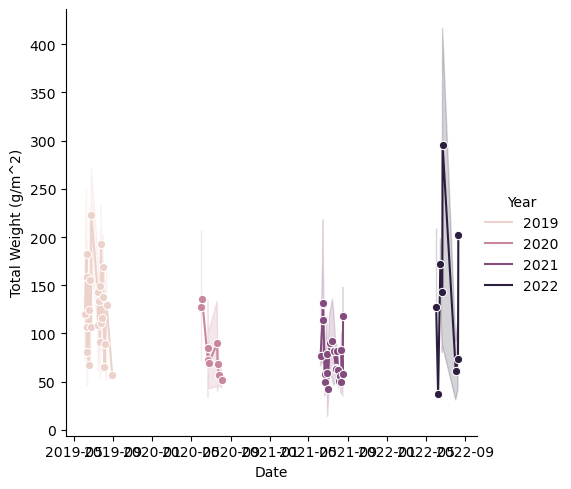

In [11]:
# plot pin-frame calibration data
sns.relplot(x='Date', y='Total Weight (g/m^2)', hue='Year',
            data=df_wtgn_bm, kind='line', marker="o")

### Add in GPS locations from shapefile

In [12]:
# update prairie dog colony column
df_wtgn_bm = df_wtgn_bm.rename(columns={'PD Colony?': 'PD'})
#df_wtgn_bm.loc[:, 'PD'] = df_wtgn_bm['Pasture'].transform(lambda x: 'Yes' if '-PD' in x else 'No')
df_wtgn_bm.loc[:, 'PD'] = df_wtgn_bm['PD'].transform(lambda x: 'Yes' if x=='y' else 'No' if x=='n' else '')

In [13]:
#df_wtgn_bm['PD'].unique()

In [14]:
#gdf_wtgn[gdf_wtgn['Plot_ID'].str.contains('Top')]

In [15]:
gdf_wtgn['Plot_ID'].apply(lambda x: '_'.join([i for i in x.split('_') if 'Pt' not in i])).unique()

array(['East_Weiss', 'West_Weiss', 'Middle_Lake_Creek', 'Center_Owens',
       'North_Owens', 'Top', 'Frey_SE', 'Frey_SW', 'Frey_NW', 'Frey_NE',
       'Frey_(Pino_Beans)', 'West_Pasture', 'South_Pasture',
       'Half_Section', 'Section_4', 'Burden_Place', 'Pellatz_South',
       'Section_8', 'Cameron_Place', "Bill's_Home", "Bill's_South",
       'Strips', 'Blue_Tank', 'East', 'PastureNE_Weiss1',
       'PastureNE_Weiss2', 'PastureNE_Weiss3', 'PastureNE_Weiss4',
       'PastureNE_Weiss5', 'PastureNE_Weiss6', 'PastureNE_Weiss7',
       'Upper_Rattlesnake', 'Miller_Place', 'West_Rattlesnake', 'Sawmill',
       'East_Rattlesnake', 'S_School_Section', 'NoName_Nacthman_634',
       'NoName_Nachtman_360', 'N_School_Section', 'Hogsback', 'Home',
       'Rattlesnake', 'Meadow', 'East_Dorr'], dtype=object)

In [16]:
past_name_dict = {
    'mid weiss G': 'East Weiss',
    'north owens': 'North Owens', 
    'mid weiss K': 'East Weiss',
    'east ne weiss': 'East Weiss', 
    'ne cameron place': 'Cameron Place',
    'north school section H': 'East Weiss',
    'east weiss K': 'East Weiss', 
    'section 4': 'Section 4',
    'west weiss E': 'West Weiss',
    'west weiss C': 'West Weiss',
    'center owens': 'Center Owens',
    'section 8': 'Section 8',
    'top': 'Top',
    'hogsback': 'Hogsback',
    'north school section': 'N School Section',
    'rattlesnake': 'Rattlesnake',
    'section 9': 'Section 4',
    'upper rattlesnake': 'Upper Rattlesnake'
}

# create unique id's of pasture+plot+PD that match for shape and clip data.
df_wtgn_bm.loc[:, 'Pasture_shp'] = df_wtgn_bm['Pasture'].transform(
    lambda x: past_name_dict[x] if x in past_name_dict.keys() else x)
df_wtgn_bm.loc[:, 'Pasture_shp'] = df_wtgn_bm['Pasture_shp'].transform(
    lambda x: re.sub(' ', '_', x))
df_wtgn_bm.loc[:, 'Join_ID'] = df_wtgn_bm.apply(lambda x: '_'.join([x['Pasture_shp'], 
                                    'Pt' + str(x['Plot']),
                                    x['PD']]),
                 axis=1)#.Pasture.unique()

In [17]:
gdf_wtgn.loc[gdf_wtgn['pdog'].isnull(), 'pdog'] = 'No'

In [18]:
gdf_wtgn.loc[:, 'Join_ID'] = gdf_wtgn.apply(lambda x: '_'.join([x['Plot_ID'], x['pdog']]), axis=1)

In [19]:
gdf_wtgn['Mean.GPS_E.Biomass'] = gdf_wtgn.geometry.centroid.x
gdf_wtgn['Mean.GPS_N.Biomass'] = gdf_wtgn.geometry.centroid.y

In [20]:
df_wtgn_bm.Pasture.unique()

array(['ne cameron place', 'center owens', 'east ne weiss', 'mid weiss G',
       'mid weiss K', 'north owens', 'north school section H',
       'section 8', 'top', 'east weiss K', 'section 4', 'west weiss E',
       'west weiss C', 'hogsback', 'north school section', 'rattlesnake',
       'upper rattlesnake'], dtype=object)

In [21]:
df_wtgn_bm = pd.merge(df_wtgn_bm,
                      gdf_wtgn[['Join_ID', 'Mean.GPS_E.Biomass', 'Mean.GPS_N.Biomass']],
                      on= 'Join_ID',
                      suffixes=['_clip', '_shp'],
                      how='left')

In [22]:
#df_wtgn_bm

In [23]:
df_wtgn_bm.to_csv(os.path.join(os.getcwd(), outDIR_clip, 'TB_wtgn_clip.csv'), index=False)

# VOR

### *Additional cleaning*

In [24]:
df_wtgn_vor = df_wtgn_vor.rename(columns={'PD Colony?': 'PD'})
df_wtgn_vor.loc[:, 'PD'] = df_wtgn_vor['PD'].transform(lambda x: 'Yes' if x=='y' else 'No' if x=='n' else '')
df_wtgn_vor.columns

Index(['entered by', 'observers', 'ranch', 'pasture', 'PD', 'Plot', 'photos',
       'pre graze reading?', 'post graze reading?', 'Date', 'Year',
       'distance (m)', 'VOR position', 'reading (high/low)', 'VOR',
       'VOR_adjusted', 'species', 'notes', '5m east adjusted northing',
       '5m east adjusted easting', 'trimble pt', '3m VOR distance'],
      dtype='object')

In [25]:
df_wtgn_vor['PD'].unique()

array(['No', 'Yes'], dtype=object)

In [26]:
# drop data with missing dates
df_wtgn_vor = df_wtgn_vor[~df_wtgn_vor['Date'].isin(['nan', 'na', np.nan])]
# drop data with note about plot center
df_wtgn_vor = df_wtgn_vor[~(df_wtgn_vor['notes'].notnull() &
                           df_wtgn_vor['notes'].str.contains('2.5m across center of plot'))]

In [27]:
# convert date column to datetime object
df_wtgn_vor.loc[:, 'Date'] = pd.to_datetime(df_wtgn_vor['Date'])

# get subset of 2019 data to drop based solely on sample date
df_wtgn_vor_2019_bad = df_wtgn_vor[df_wtgn_vor['Date'] <= datetime.datetime(2019, 6, 24)]

In [28]:
"""drop all data collected prior to 06/24/2019 and 
plots resampled in 2019 that were first sampled prior"""
# get unique pasture/plot/position combos that were sampled prior to 2019 cut-off date
vor_bad_ids = df_wtgn_vor_2019_bad.apply(lambda x: '_'.join([x['pasture'],
                                                             x['PD'],
                                                             str(x['Plot']),
                                                             x['VOR position'],
                                                             str(x['Date'].year)]), axis=1)

# remove all matching id's from dataset
df_wtgn_vor = df_wtgn_vor[~df_wtgn_vor.apply(lambda x: '_'.join([x['pasture'],
                                                                 x['PD'],
                                                                 str(x['Plot']),
                                                                 x['VOR position'],
                                                                 str(x['Date'].year)]), axis=1).isin(vor_bad_ids)]

In [29]:
df_wtgn_vor.loc[df_wtgn_vor['species'].isnull(), 'species'] = ''

In [30]:
df_wtgn_vor['species'] = df_wtgn_vor['species'].apply(lambda x: re.sub(' ', '', x) if (x.endswith(' ') or x.startswith(' ')) else x)

In [31]:
#df_wtgn_vor['species'][~df_wtgn_vor['species'].isin(ground_spp+vor_spp_drop_list)].sort_values().unique()#.sort()

In [32]:
# convert all VOR readings > 90 cm to 90 cm and store as integers
df_wtgn_vor.loc[df_wtgn_vor['VOR_adjusted'] == '>90', 'VOR_adjusted'] = np.nan
df_wtgn_vor.loc[df_wtgn_vor['VOR_adjusted'] == '90+', 'VOR_adjusted'] = np.nan
df_wtgn_vor['VOR_adjusted'] = df_wtgn_vor['VOR_adjusted'].astype(float)

# create list of non-veg species
non_veg_spp = ['BARE', 'Bare', 'BARE/MOSS', 'DUNG', 'ROCK', 'LITTER', 'dead log']
# create list of species to drop from VOR data
vor_spp_drop_list = ['ARFI', 'ARTR', 'ARCA', 'ATCA', 'ATGA', 'CHVI', 'ERNA', 'EREF', 'KRLA', 'RHTR', 'SAVE',
                     'arfi', 'artr', 'arca', 'atca', 'atga', 'chvi', 'erna', 'eref', 'krla', 'rhtr', 'save',
                     'OPPO', 'oppo',
                     'SD ARTR', 'SD ATCA', 'PASM/SD ARTR', 'AGCR/ARTR', 'OPPO/PASM']

# drop VOR readings in species list
df_wtgn_vor_spp_bad = df_wtgn_vor[df_wtgn_vor['species'].isin(vor_spp_drop_list)]

# get unique pasture/plot/position combos that were sampled prior to 2019 cut-off date
vor_bad_ids2 = df_wtgn_vor_spp_bad.apply(lambda x: '_'.join([x['pasture'],
                                                             x['PD'],
                                                             str(x['Plot']),
                                                             x['VOR position'],
                                                             str(x['Date'])]), axis=1)

# remove all matching id's from dataset
df_wtgn_vor = df_wtgn_vor[~df_wtgn_vor.apply(lambda x: '_'.join([x['pasture'],
                                                                 x['PD'],
                                                                 str(x['Plot']),
                                                                 x['VOR position'],
                                                                 str(x['Date'])]), axis=1).isin(vor_bad_ids2)]

In [33]:
# remove all VOR values of -1
df_wtgn_vor = df_wtgn_vor[~(df_wtgn_vor['VOR_adjusted'] < 0.0)]

In [34]:
# check species of any 0 value readings
df_wtgn_vor[df_wtgn_vor['VOR_adjusted'] < 1]['species'].unique()

array(['BARE', 'BARE/MOSS', 'PASM', 'MAGR', '', 'BOGR', 'ERPA', 'BRTE',
       'BRAR', 'KOMA', 'TEAC', 'CAFI', 'ARPU', 'PLPA', 'HECO', 'OOMU',
       'LOAR', 'CALO', 'Bare', 'PF', 'ALTE', 'SCSC'], dtype=object)

In [35]:
# drop any readings of non-veg species that are > 0
df_wtgn_vor = df_wtgn_vor[~(df_wtgn_vor['species'].isin(non_veg_spp) & (df_wtgn_vor['VOR_adjusted'] > 0))]

In [36]:
# add 1 to all VOR readings that have a non-bare species value
#df_wtgn_vor.loc[:, 'VOR_adjusted'] = df_wtgn_vor.apply(
#    lambda x: x['VOR_adjusted'] if x['species'] in non_veg_spp else x['VOR_adjusted'] + 1, axis=1)

### *Additional prep*

In [37]:
# get mean of any repeat measurements within groups
df_wtgn_vor = df_wtgn_vor.groupby(['pasture', 'PD', 'Plot', 'Date', 
                         'VOR position', 'reading (high/low)'])['VOR_adjusted'].mean().reset_index()
# separate low and high VOR readings to separate columns
df_wtgn_vor = df_wtgn_vor.pivot(index=['pasture', 'PD', 'Plot', 'Date', 
                         'VOR position'], 
                  columns='reading (high/low)', values='VOR_adjusted').reset_index()
# rename VOR columns to match other datasets
df_wtgn_vor = df_wtgn_vor.rename(columns={'low': 'Low_cm',
                                          'high': 'High_cm'})
# drop name associated with columns
df_wtgn_vor.columns.name = None

# drop VOR where low > high as suspected data entry errors
df_wtgn_vor = df_wtgn_vor[df_wtgn_vor['Low_cm'] <= df_wtgn_vor['High_cm']]

### *Combine with biomass dataset*

In [38]:
df_wtgn_bm['Pasture'].unique()

array(['ne cameron place', 'center owens', 'east ne weiss', 'mid weiss G',
       'mid weiss K', 'north owens', 'north school section H',
       'section 8', 'top', 'east weiss K', 'section 4', 'west weiss E',
       'west weiss C', 'hogsback', 'north school section', 'rattlesnake',
       'upper rattlesnake'], dtype=object)

In [39]:
[x for x in df_wtgn_bm['Pasture'].unique() if x not in df_wtgn_vor['pasture'].unique()]

[]

In [40]:
[x for x in df_wtgn_vor['pasture'].unique() if x not in df_wtgn_bm['Pasture'].unique()]

['downey 5-6', 'middle lake creek', 'section 9']

In [41]:
# prep for creating unique ID's
df_wtgn_vor = df_wtgn_vor.rename(columns={'pasture': 'Pasture'})
df_wtgn_vor['Plot'] = df_wtgn_vor['Plot'].astype(int)
df_wtgn_vor = df_wtgn_vor[df_wtgn_vor['Pasture'].notnull()]

In [42]:
df_wtgn_vor.columns

Index(['Pasture', 'PD', 'Plot', 'Date', 'VOR position', 'High_cm', 'Low_cm'], dtype='object')

In [43]:
# create unique id's of pasture+plot+PD that match for shape and clip data.
df_wtgn_vor.loc[:, 'Pasture_shp'] = df_wtgn_vor['Pasture'].transform(
    lambda x: past_name_dict[x] if x in past_name_dict.keys() else x)
df_wtgn_vor.loc[:, 'Pasture_shp'] = df_wtgn_vor['Pasture_shp'].transform(
    lambda x: re.sub(' ', '_', x))
df_wtgn_vor.loc[:, 'Join_ID'] = df_wtgn_vor.apply(lambda x: '_'.join([x['Pasture_shp'], 
                                    'Pt' + str(x['Plot']),
                                    x['PD']]),
                 axis=1)

### Save VOR data to disk prior to joining with clipped data

In [44]:
# get mean of each experimental unit
df_wtgn_vor_out = df_wtgn_vor.groupby(
    ['Date', 'Pasture', 'PD', 'Plot', 'Join_ID']).mean().reset_index()

# reset the year column
df_wtgn_vor_out['Year'] = df_wtgn_vor_out['Date'].dt.year

# get count of valid VOR observations and drop any <= 2 (50%)
df_wtgn_vor_out['vor_reading_ct'] = df_wtgn_vor.groupby(
    ['Date', 'Pasture', 'PD', 'Plot']).count().reset_index()['Low_cm']
df_wtgn_vor_out = df_wtgn_vor_out[df_wtgn_vor_out['vor_reading_ct'] > 2]

# join GPS locs to VOR data
df_wtgn_vor_out = pd.merge(df_wtgn_vor_out,
                           gdf_wtgn[['Join_ID', 'Mean.GPS_E.Biomass', 'Mean.GPS_N.Biomass']],
                           on= 'Join_ID',
                           suffixes=['_vor', '_shp'],
                           how='left')

# save to disk
df_wtgn_vor_out.to_csv(os.path.join(os.getcwd(), outDIR_vor, 'TB_wtgn_vor.csv'), index=False)

### Merge VOR and clipping data

In [45]:
# join Biomass and VOR datasets using Biomass dates with a definted maximum threshold of date difference
df_wtgn_vor = pd.merge_asof(df_wtgn_vor.sort_values('Date'), 
              df_wtgn_bm.sort_values('Date')[['Date',
                                              'Pasture',
                                              'PD',
                                              'Plot',
                                              'Total Weight (g/m^2)',
                                              'Mean.GPS_E.Biomass',
                                              'Mean.GPS_N.Biomass']],
                           left_on='Date',
                           right_on='Date',
                           by=['Pasture', 'PD', 'Plot'],
                           direction='nearest',
                           tolerance=datetime.timedelta(days=10),
                           suffixes=['_x', ''],)

In [46]:
# drop any records missing Biomass data
df_wtgn_vor = df_wtgn_vor[df_wtgn_vor['Total Weight (g/m^2)'].notnull()]

### *Create dataset of mean values by experimental unit*

In [47]:
# get mean of each experimental unit
df_wtgn_vor_agg = df_wtgn_vor.groupby(
    ['Date', 'Pasture', 'PD', 'Plot']).mean().reset_index()

# reset the year column
df_wtgn_vor_agg['Year'] = df_wtgn_vor_agg['Date'].dt.year

In [48]:
# get count of valid VOR observations and drop any <= 2 (50%)
df_wtgn_vor_agg['vor_reading_ct'] = df_wtgn_vor.groupby(
    ['Date', 'Pasture', 'PD', 'Plot']).count().reset_index()['Low_cm']

df_wtgn_vor_agg = df_wtgn_vor_agg[df_wtgn_vor_agg['vor_reading_ct'] > 2]

### *Check data and save to disk*

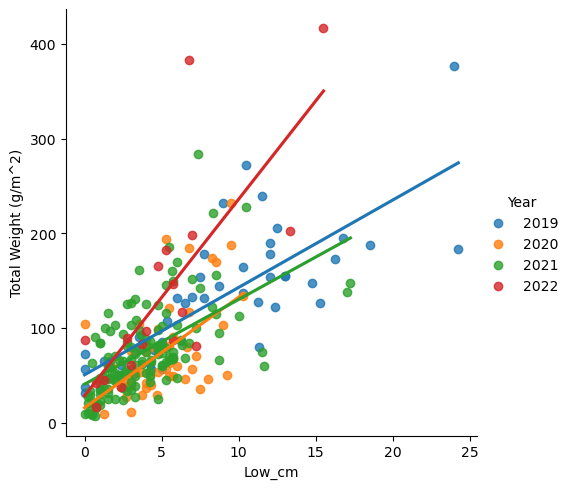

In [49]:
# plot linear fit of low VOR reading and Biomass
sns.lmplot(
    #x='High_cm', 
    x='Low_cm',
    y='Total Weight (g/m^2)',
    hue='Year', ci=None,
    data=df_wtgn_vor_agg)

In [50]:
#df_wtgn_bm.columns

In [51]:
# save final data to disk
df_wtgn_vor_agg.to_csv(os.path.join(os.getcwd(), outDIR_vor_train, 'TB_wtgn_vor_train.csv'), index=False)

In [52]:
import statsmodels.formula.api as smf
mod_both = smf.ols("np.sqrt(Q('Total Weight (g/m^2)')) ~ High_cm + Low_cm", data=df_wtgn_vor_agg).fit()

In [53]:
mod_both.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                    
==============================================================================================
Dep. Variable:     np.sqrt(Q('Total Weight (g/m^2)'))   R-squared:                       0.533
Model:                                            OLS   Adj. R-squared:                  0.529
Method:                                 Least Squares   F-statistic:                     142.7
Date:                                Thu, 01 May 2025   Prob (F-statistic):           4.63e-42
Time:                                        13:38:55   Log-Likelihood:                -544.72
No. Observations:                                 253   AIC:                             1095.
Df Residuals:                                     250   BIC:                             1106.
Df Model:                                           2                                         
Covariance Type:                            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7623      0.344     13.863      0.000       4.086       5.439
High_cm        0.1246      0.022      5.790      0.000       0.082       0.167
Low_cm         0.3193      0.047      6.764      0.000       0.226       0.412
==============================================================================
Omnibus:                       21.896   Durbin-Watson:                   1.622
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.465
Skew:                           0.656   Prob(JB):                     1.79e-06
Kurtosis:                       3.888   Cond. No.                         60.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""